In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import csv
import pandas as pd
from keras.callbacks import History
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout,Input
# import tensorflow as tf
# print(tf.__file__)
from pandas import read_csv
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["axes.unicode_minus"]=False


In [2]:
def generate_diff(input_array):
    output_array = [0]  # 初始值设为0
    
    for i in range(1, len(input_array)):
        output_array.append(input_array[i] - input_array[i - 1])
        
    return output_array
    
# load data
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')

dataset = read_csv('2012-2016.csv')
dataset['DateTime'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'])



# # 将 Time 列转换为时间格式
# dataset['Time'] = pd.to_datetime(dataset['Time'])

# # 指定时间范围
# start_time = pd.to_datetime("8:44:00").time()
# end_time = pd.to_datetime("10:30:10").time()

# 选择指定时间范围内的数据
# selected_data = dataset[(dataset['Time'].dt.time >= start_time) & (dataset['Time'].dt.time <= end_time)]
selected_data=dataset


###### 新的一天，将diff设置为0
#selected_data.loc[dataset['Date'] != dataset['Date'].shift(), ['Diff','Diff_Pct']] = 0

#######
selected_data.set_index('DateTime', inplace=True)
selected_data.drop(columns=['Time','Date'], inplace=True)

selected_data=selected_data.dropna()
# summarize first 5 rows
# print(selected_data.head(5))

df_resampled = selected_data.resample('5T').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'TotalVolume': 'sum',
})
df_resampled['Diff_Pct'] = df_resampled['Close'].pct_change()
df_resampled['Diff'] = df_resampled['Close'].diff()
df_resampled["C-L"] = df_resampled["Close"] - df_resampled["Low"]
df_resampled["H-L"] = df_resampled["High"] - df_resampled["Low"]
df_resampled["%K"] = (df_resampled["C-L"] / df_resampled["H-L"]) * 100
# 计算%D指标，这里采用3周期的简单移动平均
df_resampled["%D"] = df_resampled["%K"].rolling(window=3).mean()

# RSI
df_resampled['Gain'] = df_resampled['Diff'].apply(lambda x: x if x > 0 else 0)
df_resampled['Loss'] = df_resampled['Diff'].apply(lambda x: -x if x < 0 else 0)

# 计算平均的上涨和下跌价格变化（使用14天的时间窗口）
window = 14
df_resampled['AvgGain'] = df_resampled['Gain'].rolling(window=window).mean()
df_resampled['AvgLoss'] = df_resampled['Loss'].rolling(window=window).mean()
# 计算相对强度（RS）
df_resampled['RS'] = df_resampled['AvgGain'] / df_resampled['AvgLoss']
# 计算RSI
df_resampled['RSI'] = 100 - (100 / (1 + df_resampled['RS']))
df_resampled.drop(columns=['RS','AvgLoss','AvgGain','Gain', 'Loss'], inplace=True)

# 如果你想要去掉NaN值，可以使用以下代碼
df_resampled = df_resampled.dropna()
print(df_resampled[:6])


# # save to file


                       Open    High     Low   Close  TotalVolume  Diff_Pct  \
DateTime                                                                     
2012-01-02 09:50:00  7027.0  7034.0  7027.0  7027.0         1231 -0.000142   
2012-01-02 09:55:00  7027.0  7028.0  7017.0  7021.0         1340 -0.000854   
2012-01-02 10:00:00  7022.0  7022.0  7015.0  7020.0          928 -0.000142   
2012-01-02 10:05:00  7020.0  7025.0  7019.0  7022.0          525  0.000285   
2012-01-02 10:10:00  7022.0  7027.0  7021.0  7026.0          469  0.000570   
2012-01-02 10:15:00  7026.0  7026.0  7018.0  7019.0          600 -0.000996   

                     Diff  C-L   H-L         %K         %D        RSI  
DateTime                                                               
2012-01-02 09:50:00  -1.0  0.0   7.0   0.000000  57.142857  55.555556  
2012-01-02 09:55:00  -6.0  4.0  11.0  36.363636  45.454545  52.631579  
2012-01-02 10:00:00  -1.0  5.0   7.0  71.428571  35.930736  36.781609  
2012-01-02 10:0

In [3]:
# sns.set_style("darkgrid")
# plt.figure(figsize=(15,9))
# plt.plot(selected_data.index,selected_data[['Close']])
# # plt.xticks(range(0,dataset.shape[0], 10000), dataset.index[::10000],rotation=45)
# plt.title("price", fontsize=18, fontweight='bold')
# plt.xlabel("date", fontsize=18)
# plt.ylabel("close", fontsize=18)
# plt.show()

# plt.figure(figsize=(16,4))
# plt.plot(selected_data['LogDiff'])

In [4]:
def generate_y_for10(input_array):
    output_array = [] 
    
    for i in range(0, len(input_array)):
        if input_array[i]>0:
            output_array.append(2)
        elif input_array[i]<0:
            output_array.append(1)
        else:
            output_array.append(0)
    
    return output_array

def generate_y(input_array):
    output_array = []  # 初始值设为0
    
    for i in range(0, len(input_array)-1):
        output_array.append(input_array[i+1] - input_array[i])
        
    return output_array
    

values = df_resampled.values
# ensure all data is float
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
#############################################
# scaler_diff=MinMaxScaler(feature_range=(-1,1))
# t=scaler_diff.fit_transform(values[:,-1].reshape(-1,1))
# print(t)
#############################################
# normalize features
scaled = scaler.fit_transform(values)#待檢查
print(scaled)

# ##漲跌平
class_indices= generate_y_for10(values[:,5]) #diff
# 确定类别的数量
num_classes = max(class_indices) + 1

# 使用NumPy创建一个全零数组，形状为(数组长度, 类别数量)
y_label = np.zeros((len(class_indices), num_classes))
# 将对应的位置设置为1
y_label[np.arange(len(class_indices)), class_indices] = 1
# y_label=generate_y(values[:,3])#close明天相對今天增長量
print(y_label[:5])
# ##

# # 新增一列(diff 正規過後)
# # diff_n= np.array(generate_diff(scaled[:,3]))#close
# diff_n=
# # 创建布尔掩码
# mask = values[:,5] == 0.0
# # 使用布尔掩码将 b 中对应位置的值设为 0
# diff_n[mask] = 0.0
# x_label=np.hstack((scaled[:,[0,1,2,3,4,6,7]], diff_n.reshape(-1, 1)))
###########################
x_label=scaled[:,[0,1,2,3,5,7,8,9,10,11]]
# print(scaled[:5])
print(x_label[208:215])

[[0.07490754 0.07523894 0.07571077 ... 0.         0.57142854 0.5555556 ]
 [0.07490754 0.07338881 0.07262039 ... 0.36363634 0.45454544 0.5263158 ]
 [0.07336617 0.07153869 0.07200241 ... 0.71428573 0.35930735 0.3678161 ]
 ...
 [0.76387167 0.7625656  0.7660692  ... 0.         0.22222221 0.5       ]
 [0.76387167 0.7625656  0.7657602  ... 0.3333333  0.22222221 0.45      ]
 [0.76417994 0.7628739  0.7660692  ... 0.3333333  0.22222221 0.47619048]]
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
[[0.09556103 0.09404874 0.09548831 0.0943861  0.44954678 0.0052356
  0.01234568 0.25       0.51666665 0.56      ]
 [0.09494448 0.0949738  0.09548831 0.0943861  0.45776114 0.0052356
  0.02469136 0.14285713 0.39761904 0.6086956 ]
 [0.09494448 0.09374046 0.09301591 0.09191847 0.42489448 0.0052356
  0.04115226 0.09090909 0.16125542 0.4137931 ]
 [0.09247828 0.09127355 0.09270692 0.09161019 0.45364818 0.0052356
  0.01234568 0.25       0.16125542 0.39999998]
 [0.09247828 0.09158206 0.09147096 0.09

In [5]:
# values = selected_data.values
# # ensure all data is float
# values = values.astype('float32')
# scaler = MinMaxScaler(feature_range=(0,1)).fit(values)
# x_label=scaled=scaler.transform(values)
# print(x_label[:5])
# y_label=[x[5] for x in scaled]
# y_label = y_label[1:]
# print(y_label[:5])
# print(y_label[0])

# qq=np.zeros((len(y_label),8))
# qq[:,5]=np.array(y_label)
# print(qq)
# qqq=scaler.inverse_transform(qq)
# print(qqq[0,5])

In [6]:
def split_windows(data,label, seq_length):
    x=[]
    y=[]
    for i in range(len(data)-seq_length-1):
        _x=data[i:(i+seq_length),:]
        _y=label[i+seq_length]
        x.append(_x)
        y.append(_y)
    x,y=np.array(x),np.array(y)
    # print('x.shape,y.shape=\n',x.shape,y.shape)
    return x,y

def split_data(x, y, split_ratio):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=split_ratio, shuffle=False)
    return x_train, y_train, x_test, y_test



In [7]:
windowed_x, windowed_y = split_windows(x_label, y_label, 6) ##特徵序列長度#middle
print(windowed_x.shape, windowed_y.shape)

(72488, 6, 10) (72488, 3)


In [8]:
x_train, y_train, x_test, y_test = split_data(windowed_x, windowed_y, 0.2)#數據集分割 #paper test為2016年, 大概20%?
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(57990, 6, 10) (57990, 3)
(14498, 6, 10) (14498, 3)


In [9]:
model=Sequential()
model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, input_shape=(x_train.shape[1],32),return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu',kernel_initializer='normal'))
model.add(Dense(3, activation='softmax', kernel_initializer='normal'))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

history=model.fit(x_train, y_train, epochs=150, validation_data=(x_test, y_test), batch_size=300, verbose=1)

Epoch 1/150
194/194 [==============================] - 5s 12ms/step - loss: 0.9725 - accuracy: 0.4510 - val_loss: 0.9406 - val_accuracy: 0.4633
Epoch 2/150
194/194 [==============================] - 2s 9ms/step - loss: 0.9567 - accuracy: 0.4502 - val_loss: 0.9424 - val_accuracy: 0.4419
Epoch 3/150
194/194 [==============================] - 2s 9ms/step - loss: 0.9566 - accuracy: 0.4517 - val_loss: 0.9396 - val_accuracy: 0.4533
Epoch 4/150
194/194 [==============================] - 2s 9ms/step - loss: 0.9555 - accuracy: 0.4512 - val_loss: 0.9402 - val_accuracy: 0.4633
Epoch 5/150
194/194 [==============================] - 2s 9ms/step - loss: 0.9551 - accuracy: 0.4508 - val_loss: 0.9361 - val_accuracy: 0.4633
Epoch 6/150
194/194 [==============================] - 2s 9ms/step - loss: 0.9529 - accuracy: 0.4533 - val_loss: 0.9353 - val_accuracy: 0.4432
Epoch 7/150
194/194 [==============================] - 2s 9ms/step - loss: 0.9522 - accuracy: 0.4525 - val_loss: 0.9337 - val_accuracy: 0.463

In [10]:
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 32)             5504      
                                                                 
 dropout (Dropout)           (None, 6, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 14979 (58.51 KB)
Trainable params: 14979 (

In [11]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

454/454 [==============================] - 1s 1ms/step


In [12]:

# print(train_predict.shape)
# tr_predict=np.zeros((train_predict.shape[0], 8))
# te_predict=np.zeros((test_predict.shape[0], 8))

# tr_predict[:,5]=train_predict.squeeze()
# te_predict[:,5]=test_predict.squeeze()
# print(tr_predict[0])
# print(tr_predict.shape,te_predict.shape)

# tr_predict=scaler.inverse_transform(tr_predict)
# tr_predict=[x[5] for x in tr_predict]


# te_predict=scaler.inverse_transform(te_predict)
# te_predict=[x[5] for x in te_predict]
# # print(te_predict)

# print(tr_predict[:5])
# print(te_predict[:5])

In [13]:
# def custom_accuracy(array1, array2):
#     total_elements = len(array1)
#     correct_matches = 0

#     for val1, val2 in zip(array1, array2):
#         if (val1 > 0 and val2 > 0) or (val1 < 0 and val2 < 0):
#             correct_matches += 1
#         elif val1 == 0 and val2 == 0:
#             correct_matches += 1

#     accuracy = correct_matches / total_elements
#     return accuracy

# # for i in tr_predict:
# #     if i <=0 :
# #         print('y')
# yT=np.zeros((y_train.shape[0], 8))
# yT[:,5]=y_train.squeeze()
# yT=scaler.inverse_transform(yT)
# yT=[x[5] for x in yT]

# yt=np.zeros((y_test.shape[0], 8))
# yt[:,5]=y_test.squeeze()
# yt=scaler.inverse_transform(yt)
# yt=[x[5] for x in yt]

# print(custom_accuracy(tr_predict,yT))
# print(custom_accuracy(te_predict,yt))
# print(tr_predict[:5], y_train[:5])


In [17]:



    
test_predict_argmax = np.argmax(test_predict, axis=1)
# 将真实标签转换为真实的类别索引
y_test_argmax = np.argmax(y_test, axis=1)
# 计算准确率
accuracy = np.mean(y_test_argmax == test_predict_argmax)
print("Accuracy test:", accuracy)

np.save('5_test.npy', test_predict_argmax)

train_predict_argmax = np.argmax(train_predict, axis=1)
# 将真实标签转换为真实的类别索引
y_train_argmax = np.argmax(y_train, axis=1)
# 计算准确率
accuracy = np.mean(y_train_argmax == train_predict_argmax)
print("Accuracy train:", accuracy)

np.save('5_train.npy', train_predict_argmax)


idx_l=[]
for idx, value in enumerate(test_predict_argmax):
    if value == 0:
        idx_l.append(idx)

# print(idx_l)
idx_ll=[]
for idx, value in enumerate(y_test_argmax):
    if value == 0:
        idx_ll.append(idx)

print(len(idx_l),len(idx_ll))

##drop 0.2 兩次 step=6 RSI 8:30~10:30
# Accuracy test: 0.4788966691167937
# Accuracy train: 0.47840300210843956
#全時段
# Accuracy test: 0.4549774716169764
# Accuracy train: 0.45354446631858253


Accuracy test: 0.4755138639812388
Accuracy train: 0.5001551991722711
1 1374


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


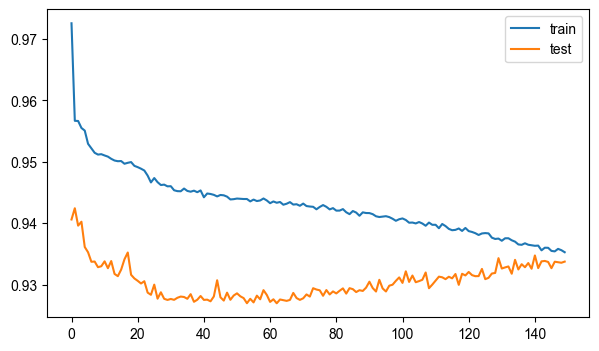

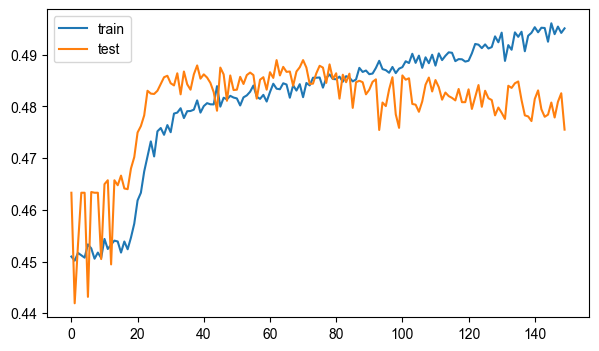

In [15]:
print(history.history.keys())
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial']  # 可以指定多个字体备选
plt.rcParams['axes.unicode_minus'] = False  # 用于解决负号显示问题
# plot history
plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# plot history
plt.figure(figsize=(7, 4))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()


